# CODSOFT INTERNSHIP, OCTOBER - NOVEMBER, 2023

## DOMAIN : ARTIFICIAL INTELLIGENCE

### PROBLEM STATEMENT :  Image Captioning

Combine computer vision and natural language processing to build an image captioning AI. Use pre-trained image recognition models like VGG or ResNet to extract features from images, and then use a recurrent neural network (RNN) or transformer-based model to generate captions for those images.

### SOLUTION

### AUTHOR : ARITRA BAG

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/flickr8k/captions.txt
/kaggle/input/flickr8k/Images/3226254560_2f8ac147ea.jpg
/kaggle/input/flickr8k/Images/214543992_ce6c0d9f9b.jpg
/kaggle/input/flickr8k/Images/2366643786_9c9a830db8.jpg
/kaggle/input/flickr8k/Images/3368819708_0bfa0808f8.jpg
/kaggle/input/flickr8k/Images/2190227737_6e0bde2623.jpg
/kaggle/input/flickr8k/Images/2752809449_632cd991b3.jpg
/kaggle/input/flickr8k/Images/3097776588_312932e438.jpg
/kaggle/input/flickr8k/Images/1206506157_c7956accd5.jpg
/kaggle/input/flickr8k/Images/1319634306_816f21677f.jpg
/kaggle/input/flickr8k/Images/2465218087_fca77998c6.jpg
/kaggle/input/flickr8k/Images/3351493005_6e5030f596.jpg
/kaggle/input/flickr8k/Images/2949337912_beba55698b.jpg
/kaggle/input/flickr8k/Images/534886684_a6c9f40fa1.jpg
/kaggle/input/flickr8k/Images/3543600125_223747ef4c.jpg
/kaggle/input/flickr8k/Images/2174206711_11cb712a8d.jpg
/kaggle/input/flickr8k/Images/280706862_14c30d734a.jpg
/kaggle/input/flickr8k/Images/2100735137_05c6079537.jpg
/kaggle/input/f

### RENAMING DIRECTORIES

In [2]:
ROOT_DIR = '/kaggle/input/flickr8k'
TEMP_DIR = '/kaggle/working'

### IMPORTING LIBRARIES

In [3]:
!pip install tqdm

import os
import pickle
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu

from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.utils import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Model
from keras.utils import to_categorical, plot_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, Flatten, GlobalAveragePooling2D, add

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### IMAGE FEATURE EXTRACTION WITH PRETRAINED MODEL

In [4]:
#Getting Base Model for feature extraction
reference_model = InceptionV3(input_shape = (299,299,3), include_top = False, weights="imagenet")
model = reference_model.output
model = Flatten()(model)
model = Dense(2048, activation = 'relu')(model)
base_model = Model(inputs = reference_model.inputs, outputs = model)

img_features = {}
img_folder = os.path.join(ROOT_DIR, 'Images')

#Feature_extraction
for img_name in tqdm(os.listdir(img_folder)):
    #Selecting Individual Images
    img_path = img_folder + '/' + img_name
    image = load_img(img_path, target_size = (299,299))
    #Conversion to numpy array and reshaping as base_model input
    img_array = img_to_array(image)
    img_input = img_array.reshape(1,  img_array.shape[0], img_array.shape[1], img_array.shape[2])
    #Feature generation with preprocessed input
    img_preprocessed = preprocess_input(img_input)
    features = base_model.predict(img_preprocessed, verbose = 0)
    #Storing the features wrt to the image
    img_id = img_name.split('.')[0]
    img_features[img_id] = features

#Storing the image features
pickle.dump(img_features, open(os.path.join(TEMP_DIR, 'image_features.pkl'), 'wb'))

#Storing the feature extractor
pickle.dump(base_model, open(os.path.join(TEMP_DIR, 'feature_extractor.pkl'), 'wb'))
pickle.dump(preprocess_input, open(os.path.join(TEMP_DIR, 'input_preprocessing.pkl'), 'wb'))

plot_model(base_model, to_file = 'feature_extractor.png', show_shapes = True, show_dtype = True, show_layer_names = True)

87910968/87910968 [==============================] - 5s 0us/step


100%|██████████| 8091/8091 [10:45<00:00, 12.53it/s]


In [5]:
#Loading the image features
features = pickle.load(open(os.path.join(TEMP_DIR, 'image_features.pkl'), 'rb'))   

### CAPTION TOKENIZATION

In [6]:
#Reading caption data
with open(os.path.join(ROOT_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_data = f.read()

#Mapping images to captions
caption_mapping = {}
#Line by line processing
for line in tqdm(captions_data.split('\n')):
    #Splitting wrt comma
    tokens = line.split(',')
    if len(line) < 2:
        continue
    img_id, caption = tokens[0], tokens[1:]
    #Removing jpg extension from the Id
    img_id = img_id.split('.')[0]
    #Creating the caption mapping with the inclusion of list when required
    caption = " ".join(caption)
    if img_id not in caption_mapping:
        caption_mapping[img_id] = []
    caption_mapping[img_id].append(caption)

100%|██████████| 40456/40456 [00:00<00:00, 389666.06it/s]


In [7]:
#Getting the processed captions for the model
for key, captions in caption_mapping.items():
    for j in range (len(captions)):
        #Taking a single caption
        caption = captions[j]
        #Caption preprocessing (lower case, removing special characters and extra spaces)
        caption.lower
        caption.replace('[^A-za-z]','')
        caption.replace('\s+', ' ')
        #Adding START and STOP tags to the caption
        caption = 'starttag ' + " ".join([word for word in caption.split() if len(word)>1]) + ' stoptag'
        captions[j] = caption          

caption_list = []
for key in caption_mapping:
    for caption in caption_mapping[key]:
        caption_list.append(caption)

In [8]:
caption_list[1:10]

['starttag girl going into wooden building stoptag',
 'starttag little girl climbing into wooden playhouse stoptag',
 'starttag little girl climbing the stairs to her playhouse stoptag',
 'starttag little girl in pink dress going into wooden cabin stoptag',
 'starttag black dog and spotted dog are fighting stoptag',
 'starttag black dog and tri-colored dog playing with each other on the road stoptag',
 'starttag black dog and white dog with brown spots are staring at each other in the street stoptag',
 'starttag Two dogs of different breeds looking at each other on the road stoptag',
 'starttag Two dogs on pavement moving toward each other stoptag']

In [9]:
#Text Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(caption_list)
unique_words = len(tokenizer.word_index)+1

#Longest Caption
max_caption_length = max(len(caption.split()) for caption in caption_list)

print(unique_words)
print(max_caption_length)

8485
35


### CREATING DATA GENERATOR AND CAPTION PREDICTION FUNCTIONS

In [10]:
#Data Generator
def data_generator(data_keys, captions_mapping, features, tokenizer, max_caption_length, unique_words, batch_size):
    x_features, x_captions, y = list(), list(), list()
    n = 0
    #Looping over the entire dataset
    while 1:
        for key in data_keys:
            n+= 1
            captions = captions_mapping[key]
            #For each caption wrt to a given image with a unique key(Id)
            for caption in captions:
                #Encoding the whole sequence
                sequence = tokenizer.texts_to_sequences([caption])[0]
                #Splitting into input and output pairs
                for  i in range(1, len(sequence)):
                    input_sequence, output_sequence = sequence[:i], sequence[i]
                    #Input sequence padding
                    input_sequence = pad_sequences([input_sequence], maxlen = max_caption_length)[0]
                    #Output sequence encoding
                    output_sequence = to_categorical([output_sequence],num_classes = unique_words)[0]

                    #Storing feature, input sequence and output sequence data
                    x_features.append(features[key][0])
                    x_captions.append(input_sequence)
                    y.append(output_sequence)
                
            if n == batch_size:
                x_features, x_captions, y =  np.array(x_features), np.array(x_captions), np.array(y)
                yield [x_features, x_captions],y
                x_features, x_captions, y = list(), list(), list()
                n = 0            

In [11]:
#Function for converting the output sequence index to it's corresponding word
def index_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None


#Caption Generator
def caption_generator(model, image, tokenizer, max_caption_length):
    #Beginning with the start tag
    input_text = 'starttag '
    #Processing in between the start and stop tags
    for i in range (max_caption_length):
        sequence = tokenizer.texts_to_sequences([input_text])[0]
        sequence = pad_sequences([sequence],max_caption_length)
        y_hat = model.predict([image,sequence], verbose = 0)
        y_hat = np.argmax(y_hat)
        word = index_to_word(y_hat, tokenizer)
        #Stopping if word is not found
        if word is None:
            break
        #Appending the found word to the sequence to predict the next word
        input_text += ' ' + word
        #Stopping at the stop tag
        if word == 'stoptag':
            break
    return input_text

### MODEL CREATION

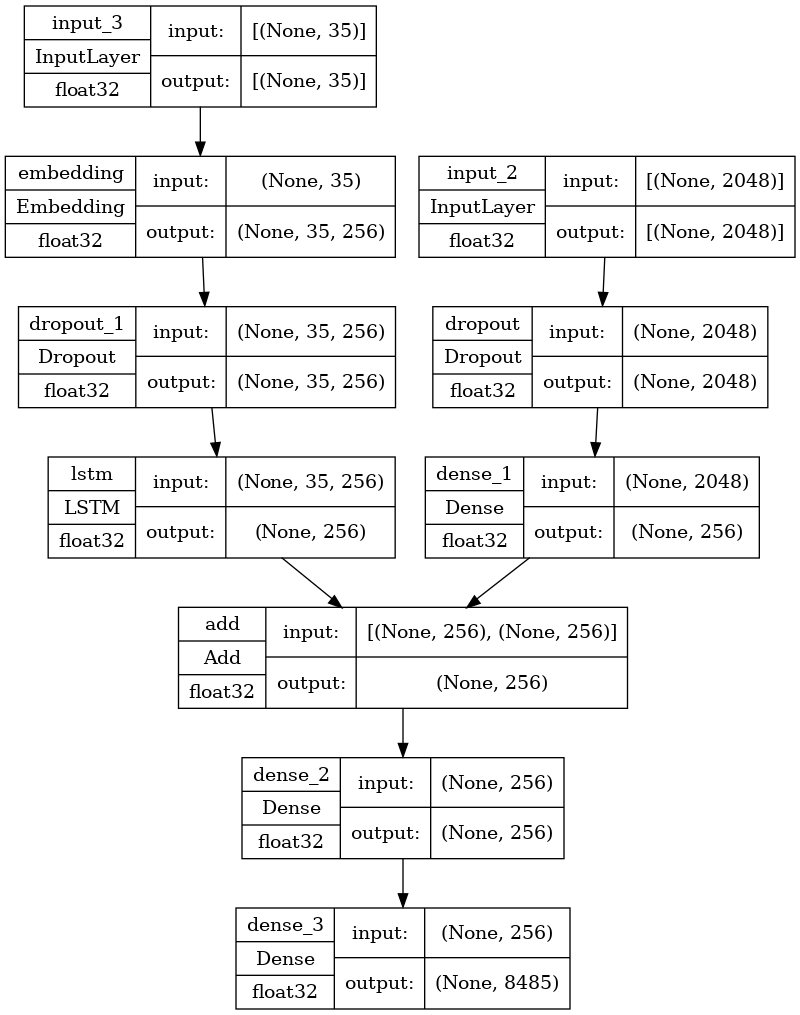

In [12]:
#Encoder Model
#Image features layers
img_inputs = Input(shape = (2048,))
img_fe1 = Dropout(0.3)(img_inputs)
img_fe2 = Dense(256, activation = 'relu')(img_fe1)

#Caption sequence layers
cap_inputs = Input(shape = (max_caption_length, ))
cap_seq1 = Embedding(unique_words, 256, mask_zero = True)(cap_inputs)
cap_seq2 = Dropout(0.3)(cap_seq1)
cap_seq3 = LSTM(256, return_sequences = False)(cap_seq2)

#Decoder Model
decoder1 = add([img_fe2, cap_seq3])
decoder2 = Dense(256, activation = 'relu')(decoder1)
outputs = Dense(unique_words, activation = 'softmax')(decoder2)

predictor = Model(inputs = [img_inputs, cap_inputs], outputs = outputs)
predictor.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

plot_model(predictor, to_file = 'caption_predictor.png', show_shapes = True, show_dtype = True, show_layer_names = True)

### TRAINING AND TEST SET CREATION

In [13]:
img_ids = list(caption_mapping.keys())
split = int(len(img_ids)*0.85)
train = img_ids[:split]
test = img_ids[split:]

### MODEL TRAINING

In [14]:
epochs = 50
batch_size = 32
steps = len(train)//batch_size

for i in range(epochs):
    print('Epoch Number : ' + str(i+1) + ' : ')
    generator = data_generator(train, caption_mapping, features, tokenizer, max_caption_length, unique_words, batch_size)
    predictor.fit(generator, epochs = 1, steps_per_epoch = steps)

Epoch Number : 1 : 
214/214 [==============================] - 61s 257ms/step - loss: 5.4599
Epoch Number : 2 : 
214/214 [==============================] - 39s 181ms/step - loss: 4.2660
Epoch Number : 3 : 
214/214 [==============================] - 39s 180ms/step - loss: 3.8146
Epoch Number : 4 : 
214/214 [==============================] - 39s 181ms/step - loss: 3.5402
Epoch Number : 5 : 
214/214 [==============================] - 39s 181ms/step - loss: 3.3478
Epoch Number : 6 : 
214/214 [==============================] - 39s 180ms/step - loss: 3.1975
Epoch Number : 7 : 
214/214 [==============================] - 38s 179ms/step - loss: 3.0731
Epoch Number : 8 : 
214/214 [==============================] - 39s 181ms/step - loss: 2.9686
Epoch Number : 9 : 
214/214 [==============================] - 39s 181ms/step - loss: 2.8703
Epoch Number : 10 : 
214/214 [==============================] - 38s 179ms/step - loss: 2.7905
Epoch Number : 11 : 
214/214 [==============================] - 38s 1

In [15]:
pickle.dump(predictor, open(os.path.join(TEMP_DIR, 'predictor.pkl'), 'wb'))
pickle.dump(tokenizer, open(os.path.join(TEMP_DIR, 'tokenizer.pkl'), 'wb'))

### REAL TIME TESTING

In [16]:
def whats_this(image_name):
    image_id = image_name.split('.')[0]
    location = os.path.join(ROOT_DIR,"Images",image_name)
    image = Image.open(location)
    captions = caption_mapping[image_id]
    plt.imshow(image)
    print('-------------------------------------------------------Actual Caption-------------------------------------------------------------')
    for caption in captions:
        print(caption)
    print('-------------------------------------------------------Predicted Caption----------------------------------------------------------')
    prediction = caption_generator(predictor, features[image_id], tokenizer, max_caption_length)
    print(prediction)

-------------------------------------------------------Actual Caption-------------------------------------------------------------
starttag man and baby are in yellow kayak on water stoptag
starttag man and little boy in blue life jackets are rowing yellow canoe stoptag
starttag man and child kayak through gentle waters stoptag
starttag man and young boy ride in yellow kayak stoptag
starttag Man and child in yellow kayak stoptag
-------------------------------------------------------Predicted Caption----------------------------------------------------------
starttag  man in yellow kayak stands in the water stoptag


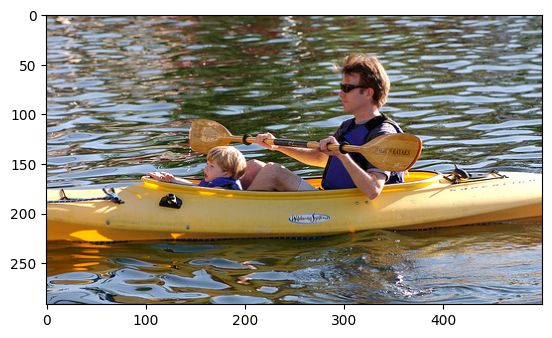

In [17]:
whats_this('1028205764_7e8df9a2ea.jpg')

-------------------------------------------------------Actual Caption-------------------------------------------------------------
starttag Two different breeds of brown and white dogs play on the beach stoptag
starttag Two dogs are making turn on soft sand beach stoptag
starttag Two dogs playing in the sand at the beach stoptag
starttag Two dogs playing together on beach stoptag
starttag Two large tan dogs play along sandy beach stoptag
-------------------------------------------------------Predicted Caption----------------------------------------------------------
starttag  two dogs one brown and one brown are playing in the sand stoptag


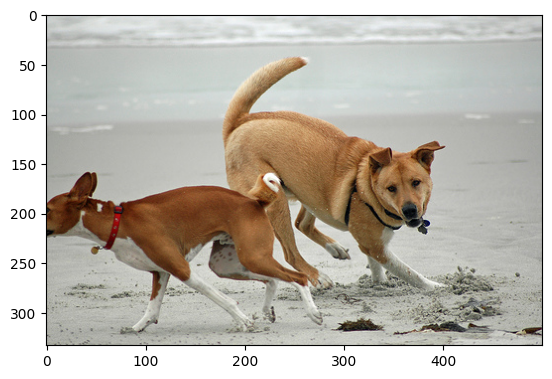

In [18]:
whats_this('1024138940_f1fefbdce1.jpg')

-------------------------------------------------------Actual Caption-------------------------------------------------------------
starttag man drilling hole in the ice stoptag
starttag man is drilling through the frozen ice of pond stoptag
starttag person in the snow drilling hole in the ice stoptag
starttag person standing on frozen lake stoptag
starttag Two men are ice fishing stoptag
-------------------------------------------------------Predicted Caption----------------------------------------------------------
starttag  man drilling hole in the snow stoptag


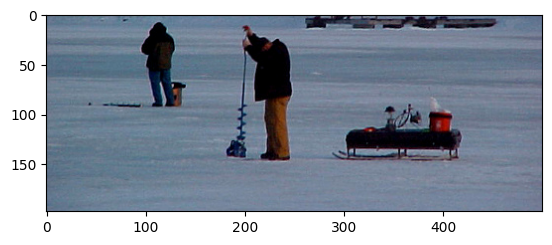

In [29]:
whats_this('102351840_323e3de834.jpg')

### MODEL EVALUTION

In [20]:
actual, predicted = list(), list()

for key in tqdm(test):
    captions = caption_mapping[key]
    y_predict = caption_generator(predictor, features[key], tokenizer, max_caption_length)
    actual_captions = [caption.split() for caption in captions]
    actual.append(actual_captions)
    y_predict_split = y_predict.split()
    predicted.append(y_predict_split) 

100%|██████████| 1214/1214 [12:12<00:00,  1.66it/s]


In [21]:
print("BLEU-1 %f" % corpus_bleu(actual, predicted, weights = (1, 0, 0, 0)))
print("BLEU-2 %f" % corpus_bleu(actual, predicted, weights = (0.5, 0.5, 0, 0)))
print("BLEU-3 %f" % corpus_bleu(actual, predicted, weights = (1./3, 1./3, 1./3, 0)))
print("BLEU-4 %f" % corpus_bleu(actual, predicted, weights = (0.25, 0.25, 0.25, 0.25)))

BLEU-1 0.503746
BLEU-2 0.265891
BLEU-3 0.152596
BLEU-4 0.086722
